## Gamma-ray fluxes for DM processes

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import astropy.units as u
from astropy.io import fits

In [172]:
plt.style.use('astroph')

## Load spectras

In [173]:
spectras = pd.read_pickle('spectras/at-production-gammas.pkl')

In [174]:
spectras.tail()

,$m_{DM}$,$\log_{10} x$,$e^L$,$e^R$,$e$,$\mu^L$,$\mu^R$,$\mu$,$\tau^L$,$\tau^R$,...,$Z$,$g\bar{g}$,$\gamma$,$h$,$\nu_e$,$\nu_{\mu}$,$\nu_{\tau}$,$VV \rightarrow 4e$,$VV \rightarrow 4\mu$,$VV \rightarrow 4\tau$
11093,100000.0,-0.20,0.120376,0.164452,0.142414,0.118679,0.162191,0.140435,0.250219,0.343664,...,0.017353,0.034521,0.006268,0.018649,0.036341,0.035359,0.062713,0.049568,0.007253,0.016084
11094,100000.0,-0.15,0.114321,0.156519,0.135420,0.112061,0.153479,0.132770,0.180252,0.247822,...,0.011076,0.020960,0.005056,0.014080,0.032615,0.031520,0.044223,0.037050,0.004981,0.006714
11095,100000.0,-0.10,0.108509,0.148947,0.128728,0.105200,0.144449,0.124824,0.129938,0.178762,...,0.006866,0.013063,0.041196,0.011203,0.028697,0.027460,0.031130,0.025530,0.003149,0.002627
11096,100000.0,-0.05,0.102214,0.140988,0.121601,0.097452,0.134443,0.115948,0.098153,0.135501,...,0.003653,0.008542,2.149326,0.009287,0.022050,0.020845,0.020311,0.015730,0.001788,0.000973
11097,100000.0,0.00,0.097123,0.135170,0.116147,0.091384,0.127185,0.109285,0.084001,0.116918,...,0.001291,0.006717,53.850927,0.008043,0.011482,0.010782,0.009848,0.008371,0.000889,0.000348


In [175]:
class SpectraQuery:

    def __init__(self, fluxes_table, mass_col='$m_{DM}$'):
        self.fluxes_table = fluxes_table
        self.mass_col = mass_col
        self.masses = fluxes_table[mass_col].unique()
        
    def get_allowed_masses(self):
        return self.masses
    
    def spectra_at_channel(self, mass, channel='$e$', log_x=r'$\log_{10} x$'):
        fluxes = self.fluxes_table.loc[self.fluxes_table[self.mass_col] == mass]
        if fluxes.shape[0] == 0:
            return 'Not a valid DM component mass.'
        energies = (10.0)**fluxes[log_x]*mass
        channel_flux = fluxes[channel]/(energies*np.log(10.0))
        return energies, channel_flux


In [176]:
query = SpectraQuery(spectras)

## Load $J$-factor maps

In [177]:
def load_fits(path):
    with fits.open(path) as hdul:
        data = hdul[0].data
    return data

In [178]:
nfw_annih = load_fits('maps/nfw_annih.fits')
einasto_annih = load_fits('maps/einasto_annih.fits')

*Aditional maps*: Apertures and $\theta$s

In [179]:
apertures = load_fits('maps/apertures.fits')
thetas = load_fits('maps/thetas.fits')

## Calculate $\bar{J}$ for GC

In [180]:
def j_bar(data, apertures, mask):
    return data[mask].sum()/apertures[mask].sum()

* $\theta < 0.1º$

In [181]:
theta1 = 1*np.pi/180.0
mask1 = (thetas <= theta1)

In [182]:
jbar01 = j_bar(nfw_annih, apertures, mask1)

In [183]:
total_aperture = apertures[mask1].sum().sum()

In [184]:
jbar01

1116.0417711198525

In [185]:
total_aperture

0.0009570178759736709

## Channels

In [186]:
masses = [5, 10, 100, 1e3]

In [212]:
colors = ['k', 'crimson',  'royalblue', 'limegreen']

**Units**

* Spectra: 1/GeV
* $m_{DM}$: GeV.
* $\rho_{\odot}$: GeV/cm³.
* $r_{\odot}$: kpc.
* $\bar J$: dimensionless.
* $\langle \sigma v \rangle$: cm³/s

In [213]:
def calculate_flux(spectra, dm_mass, j_bar, aperture,
                   sigmav=3e-26*u.cm**3/u.s,
                   r_sun=(8.33*u.kpc).to(u.cm)*u.cm,
                   rho_sun=0.3*u.GeV/u.cm**3, 
                   unit=u.erg/u.cm**2/u.s):
    flux = r_sun/(8*np.pi) * (rho_sun/dm_mass)**2 * j_bar * aperture * sigmav * spectra
    return flux*unit

### 1. $b \bar b $

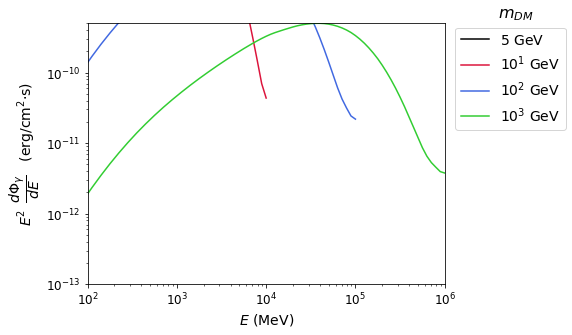

In [214]:
for mass, color in zip(masses, colors):
    # Energy is on GeV
    energy, spectra = query.spectra_at_channel(mass, channel=r'$b\bar{b}$') 
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, (energy**2 * flux), '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5*1e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.show()

### 2. $t \bar t$

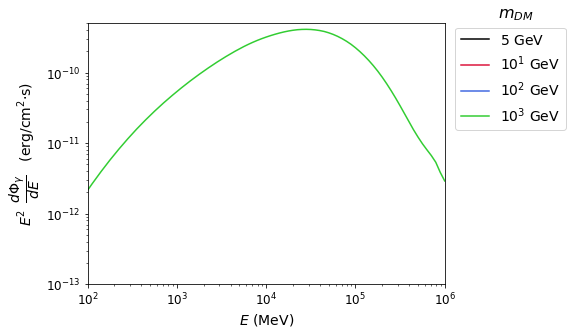

In [215]:
for mass, color in zip(masses, colors):
    energy, spectra = query.spectra_at_channel(mass, channel=r'$t\bar{t}$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, energy**2 * flux, '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.show()

### 3. $\tau^{+} \tau^{-}$

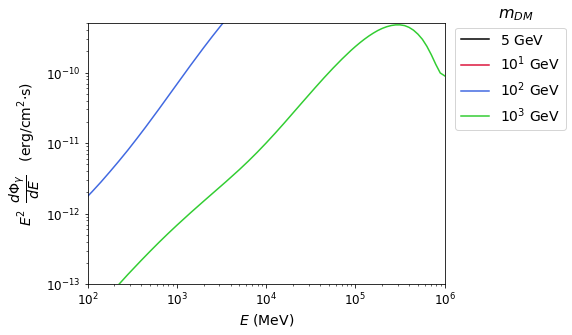

In [216]:
for mass, color in zip(masses, colors):
    energy, spectra = query.spectra_at_channel(mass, channel=r'$\tau$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, energy**2 * flux, '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.show()

### 4. $W^{+} W^{-}$

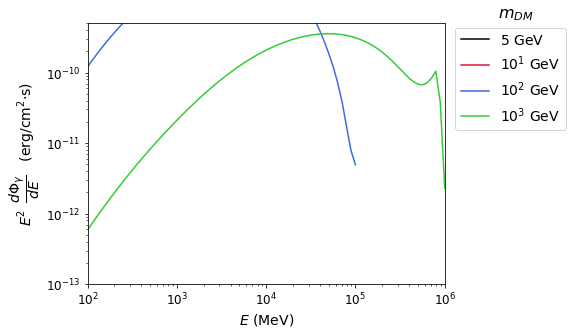

In [217]:
for mass, color in zip(masses, colors):
    energy, spectra = query.spectra_at_channel(mass, channel='$W$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, energy**2 * flux, '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.show()

## Comparing with LAT sensitivity

In [218]:
columns = ['$E_{min}$', '$E_{max}$', "$E^2 \dfrac{d\Phi}{dE}$"]

In [219]:
data = np.loadtxt('lat-dif-sensitivity/lat_dif_sensitivity.txt', comments='#')[:, :3]

In [220]:
emin, emax, energy_flux = data.T

In [221]:
pd.DataFrame(data, columns=columns).head()

,$E_{min}$,$E_{max}$,$E^2 \dfrac{d\Phi}{dE}$
0,31.622777,56.234133,1.900070e-11
1,56.234133,100.000000,1.549856e-11
2,100.000000,177.827941,1.302078e-11
3,177.827941,316.227766,1.149279e-11
4,316.227766,562.341325,9.351305e-12


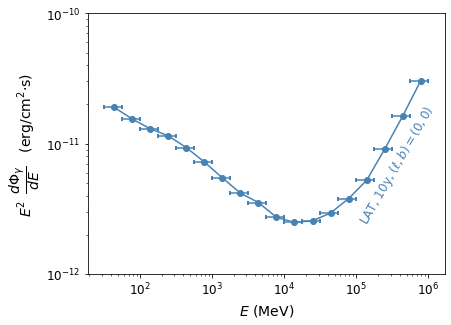

In [222]:
plt.errorbar(x=(emax+emin)/2, y=energy_flux, xerr=(emax-emin)/2, fmt='o-', markersize=6,
            color='steelblue', capsize=2, capthick=2)
plt.xscale('log', nonposx='mask')
plt.yscale('log')
plt.ylim(1e-12, 1e-10)
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.text(x=1e5, y=0.25e-11, s='LAT, 10y, $(\ell, b) = (0, 0)$',
         fontsize=12, color='steelblue', rotation=60)
plt.show()

## Comparing sensitivity with fluxes

In [223]:
channels = [r'$b\bar{b}$', r'$t\bar{t}$', r'$\tau$', '$W$']

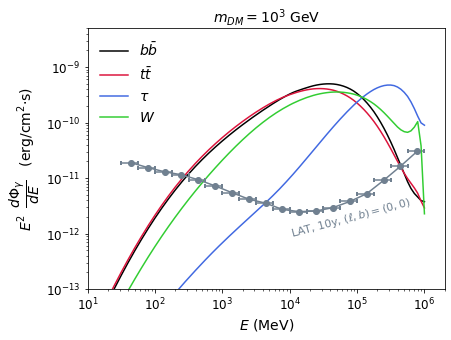

In [270]:
mass = 1e3
for channel, color in zip(channels, colors):
    energy, spectra = query.spectra_at_channel(mass, channel=channel)
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, (energy**2 * flux), '-', color=color, 
             label=channel)
    
plt.errorbar(x=(emax+emin)/2, y=energy_flux, xerr=(emax-emin)/2, fmt='o-', markersize=6,
            color='slategray', capsize=2, capthick=2)
plt.text(x=1e4, y=0.09e-11, s='LAT, 10y, $(\ell, b) = (0, 0)$',
         fontsize=11, color='slategray', rotation=15)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.title('$m_{DM} = %s$ GeV'%f._formatSciNotation('%1.10e'%mass), fontsize=14)
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-13, 5e-9)
plt.xlim(1e1, 2e6)
plt.legend(loc=2, frameon=False)
plt.show()